In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from tqdm import tqdm

In [21]:
def generateData(nTrain,nTest,d,withLamb=True,wZero=False):
    XTrain = np.random.normal(size=(nTrain,d))
    XTest = np.random.normal(size=(nTest,d))
    
    if withLamb:
        lambsTrain = np.random.uniform(0,1,nTrain)
        lambsTest = np.random.uniform(0,1,nTest)
        XTrain = np.diag(lambsTrain)@XTrain
        XTest = np.diag(lambsTest)@XTest

    if wZero:
        w = np.zeros(d)
    else:
        w = np.random.normal(size=d)/(d**(1/2))
    
    YTrain = XTrain@w + np.random.normal(size=nTrain)
    YTest = XTest@w + np.random.normal(size=nTest)
    

    return XTrain, YTrain, XTest, YTest


In [22]:
### Estimate the training-conditional coverage of full conformal ridge and its uncorrected variant
### on one draw of the training data.
def oneCovTrial(nTrain,nTest,d,alpha,tau=0.1):
    XTrain, YTrain, XTest, YTest = generateData(nTrain,nTest,d)
    
    ### run uncorrected method
    mod = Ridge(nTrain*tau, fit_intercept=False)
    mod.fit(XTrain,YTrain)
    trainResid = np.abs(YTrain - mod.predict(XTrain))
    q = np.quantile(trainResid, 1-alpha)
    uncorrCov = np.mean(np.abs(YTest - mod.predict(XTest)) <= q)
    
    ### run full conformal 
    corrCov = 0
    for i in range(nTest):
        XFull = np.row_stack((XTrain,XTest[i,:]))
        YFull = np.append(YTrain,YTest[i])
        
        
        mod = Ridge(nTrain*tau, fit_intercept=False)
        mod.fit(XFull,YFull)
        resid = np.abs(YFull - mod.predict(XFull))
        q = np.quantile(resid, 1-alpha)
        corrCov = corrCov + (resid[-1] <= q)/nTest
        
    return(uncorrCov, corrCov)


In [23]:
### Evaluate training-conditional coverage over many trials (draws of the training set) for varying dimension
nTest = 2000
nTrain = 200
ds = [10,20,40,60,100]
nTrials = 100
alpha = 0.1

res = pd.DataFrame()
for d in ds:
    for i in tqdm(range(nTrials)):
        uncorrCov, corrCov = oneCovTrial(nTrain,nTest,d,alpha)
        newRes = pd.DataFrame({
            'n' : [nTrain, nTrain],
            'Dimension' : [d, d],
            'Method' : ['Uncorrected', 'Full Conformal'],
            'Coverage' : [uncorrCov, corrCov]
        })
        res = pd.concat([res,newRes])
        

100%|█████████████████████████████████████████| 100/100 [10:30<00:00,  6.31s/it]


In [25]:
### Evaluate training-conditional coverage over many trials (draws of the training set) for varying sample sizes
nTest = 2000
nTrains = [100, 200, 400, 800]
ratio = 0.2
nTrials = 100
alpha = 0.1

resFixedRatio = pd.DataFrame()
for nTrain in nTrains:
    d = math.floor(ratio*nTrain)
    for i in tqdm(range(nTrials)):
        uncorrCov, corrCov = oneCovTrial(nTrain,nTest,d,alpha)
        newRes = pd.DataFrame({
            'Number of Training Points' : [nTrain, nTrain],
            'Dimension' : [d, d],
            'Method' : ['Uncorrected', 'Full Conformal'],
            'Coverage' : [uncorrCov, corrCov]
        })
        resFixedRatio = pd.concat([resFixedRatio,newRes])


100%|█████████████████████████████████████████| 100/100 [21:58<00:00, 13.19s/it]


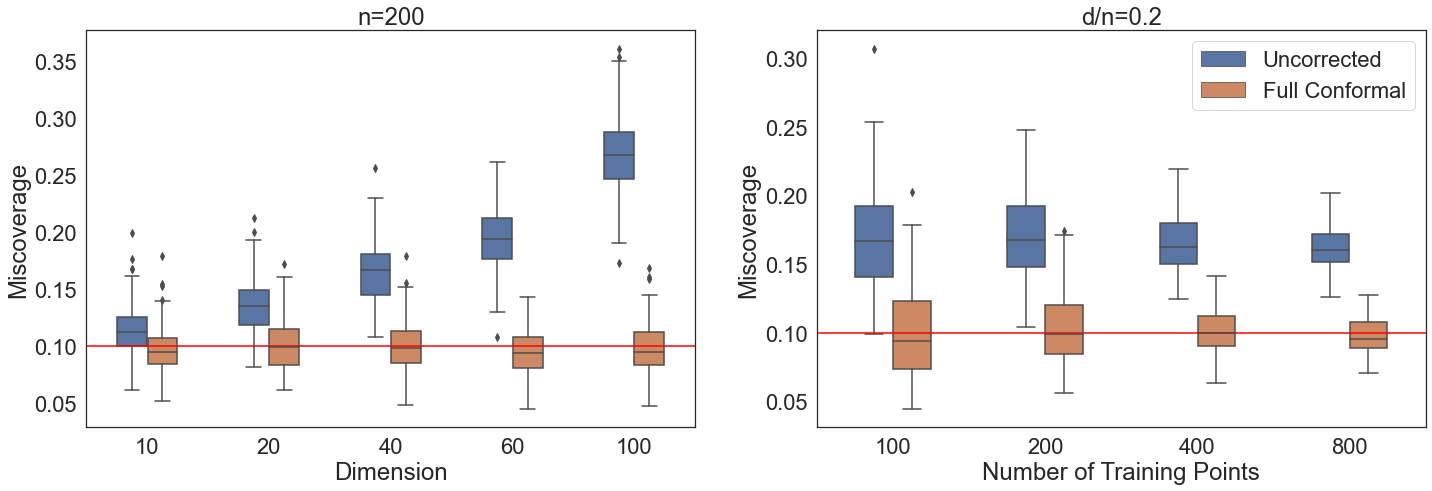

In [27]:
sns.set(rc={'figure.figsize':(24,7.3)})
sns.set(font_scale=2)
sns.set_style(style='white')
fig = plt.figure()

res['Miscoverage'] = 1 - res['Coverage']
resFixedRatio['Miscoverage'] = 1 - resFixedRatio['Coverage']

ax1 = fig.add_subplot(1,2,1)
f1 = sns.boxplot(res,x='Dimension',y='Miscoverage',hue='Method', ax = ax1, width=0.5)
f1.axhline(alpha, color='red')
plt.title('n=200')
plt.legend([],[], frameon=False)

ax2 = fig.add_subplot(1,2,2)
f2 = sns.boxplot(resFixedRatio,x='Number of Training Points',y='Miscoverage',hue='Method',ax=ax2, width=0.5)
f2.axhline(alpha, color='red')
plt.title('d/n=0.2')
plt.legend(loc='upper right')

plt.savefig('figures/HighDimRidgeCov.pdf')